In [34]:
import os
from datetime import datetime

import imageio
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.api.models import Sequential
from keras.api.losses import BinaryCrossentropy
from keras.api.optimizers import Adam
from keras.api.layers import (
    Input,
    Dense,
    LeakyReLU,
    Reshape,
    Conv2D,
    Conv2DTranspose,
    BatchNormalization,
    LeakyReLU,
    Flatten,
)

# DATASET 
The dataset used was downloaded from [Kaggle](https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art) and all images where moved into the `data` folder.

In [35]:
# Suppress TensorFlow logging messages (set to "3" to show only errors)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# List all physical GPU devices available
physical_devices = tf.config.list_physical_devices("GPU")

# Enable memory growth for the first GPU to prevent TensorFlow from allocating all memory at once
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [36]:
IMG_DIR = "data"

GRID_SIZE = (6, 6)  # Grid size for image that get saved for each epoch
IMG_SHAPE = (16, 16, 3)

NOISE_LENGTH = 100
BATCH_SIZE = 32
EPOCHS = 75
LEARNING_RATE = 1e-4

In [37]:
def create_new_folder() -> str:

    current_datetime = datetime.now().strftime("%Y-%m-%d %H-%M-%S")

    path_run = f"images/{current_datetime}"
    os.makedirs(path_run, exist_ok=True)

    return path_run

In [38]:
path_run = create_new_folder()

In [39]:
def load_data() -> np.array:
    global IMG_DIR

    # Get the list of all image file paths in the IMG_DIR directory
    img_files = [os.path.join(IMG_DIR, f) for f in os.listdir(IMG_DIR)]

    # Read each file, decode the image data, ensure it has 3 color channels, and convert to a numpy array
    images = [
        tf.image.decode_image(tf.io.read_file(file), channels=3).numpy()
        for file in img_files
    ]
    train_images = np.array(images)

    # Normalize the image pixel values to be between -1 and 1
    train_images = (train_images - 127.5) / 127.5

    return train_images

In [40]:
train_images = load_data()
train_images.shape

(12589, 16, 16, 3)

There are a total of 12589 images in the dataset. Also all images have a size of 16x16x3

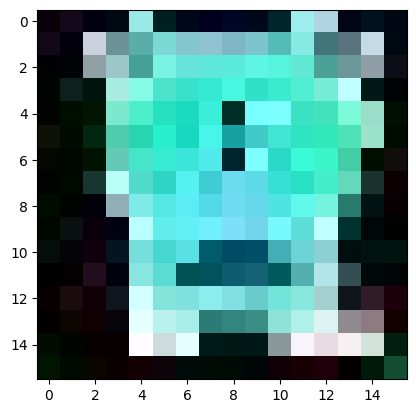

In [41]:
# Display the first image in the train_images array
# First, denormalize the image pixel values to the range [0, 255] by reversing the normalization step
plt.imshow((train_images[0] * 127.5 + 127.5).astype(np.uint8))
plt.show()

# Generator
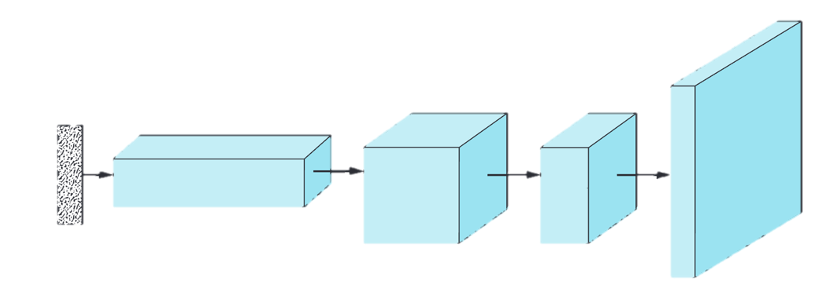

In [ ]:
def create_generator() -> Sequential:
    global NOISE_LENGTH
    return Sequential(
        [
            Input((NOISE_LENGTH,)),
            Dense(256 * 4 * 4),
            LeakyReLU(0.01),
            Reshape((4, 4, 256)),
            Conv2DTranspose(128, kernel_size=3, strides=1, padding="same"),
            BatchNormalization(),
            LeakyReLU(0.01),
            Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
            BatchNormalization(),
            LeakyReLU(0.01),
            Conv2DTranspose(
                3, kernel_size=3, strides=2, padding="same", activation="tanh"
            ),
        ]
    )

# Discriminator
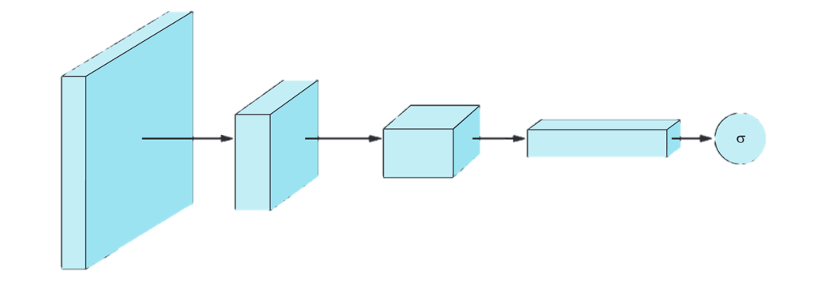

In [42]:
def create_discriminator() -> Sequential:
    global IMG_SHAPE
    return Sequential(
        [
            Input(IMG_SHAPE),
            Conv2D(32, kernel_size=3, strides=2, padding="same"),
            LeakyReLU(0.01),
            Conv2D(64, kernel_size=3, strides=2, padding="same"),
            BatchNormalization(),
            LeakyReLU(0.01),
            Conv2D(128, kernel_size=3, strides=2, padding="same"),
            BatchNormalization(),
            LeakyReLU(0.01),
            Flatten(),
            Dense(1),
        ]
    )

In [43]:
cross_entropy = BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output: list, fake_output: list) -> float:
    global cross_entropy
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output: list) -> list:
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [45]:
generator_optimizer = Adam(learning_rate=LEARNING_RATE)
discriminator_optimizer = Adam(learning_rate=LEARNING_RATE)


@tf.function
def train_step(
    images: list, generator: Sequential, discriminator: Sequential
) -> tuple[float, float]:
    # Declare global variables
    global BATH_SIZE, NOISE_LENGTH, generator_optimizer, discriminator_optimizer

    # Generate random noise as input for the generator
    noise = tf.random.normal([BATH_SIZE, NOISE_LENGTH])

    # Record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images from the noise
        generated_images = generator(noise, training=True)

        # Get discriminator predictions for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate generator and discriminator losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients for the generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    # Apply gradients to update the generator and discriminator
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    return gen_loss, disc_loss

In [46]:
def generate_and_save_images(epoch: int, generator: Sequential) -> None:
    # Use global variables for noise length and grid size
    global NOISE_LENGTH, GRID_SIZE

    # Generate random noise vectors for the generator
    noise = tf.random.normal([GRID_SIZE[0] * GRID_SIZE[1], NOISE_LENGTH])
    # Generate images from the noise using the generator (set training=False for inference mode)
    predictions = generator(noise, training=False)

    # Create a figure with subplots arranged in a grid
    fig, axes = plt.subplots(GRID_SIZE[0], GRID_SIZE[1], figsize=(16, 16))
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    for i, ax in enumerate(axes.flat):
        # Denormalize the image pixel values to the range [0, 255] and convert to uint8
        image = (predictions[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8)
        ax.imshow(image, cmap=None)
        ax.axis("off")

    # Save the figure with the generated images, labeled by epoch number
    plt.savefig(
        f"{path_run}/epoch_{epoch:02d}.png",
        bbox_inches="tight",
        pad_inches=0,
    )
    # Close the figure to free up memory
    plt.close(fig)

In [47]:
def train(dataset, epochs: int = EPOCHS) -> tuple[Sequential, Sequential, dict, dict]:

    generator = create_generator()
    discriminator = create_discriminator()

    # Initialize dictionaries to store generator and discriminator losses for each epoch
    generator_losses = {}
    discriminator_losses = {}

    #
    for epoch in tqdm(range(epochs)):
        # Initialize lists to store losses for the current epoch
        generator_losses[epoch] = []
        discriminator_losses[epoch] = []

        for image_batch in dataset:
            # Perform a training step and get the losses
            generator_loss, discriminator_loss = train_step(
                image_batch, generator, discriminator
            )

            # Append the losses to the lists for the current epoch
            generator_losses[epoch].append(generator_loss)
            discriminator_losses[epoch].append(discriminator_loss)

        generate_and_save_images(epoch + 1, generator)

    return generator, discriminator, generator_losses, discriminator_losses

In [ ]:
# Create a TensorFlow dataset from the training images
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        train_images
    )  # Convert the array of images to a dataset
    .shuffle(
        train_images.shape[0]
    )  # Shuffle the dataset with a buffer size equal to the number of images
    .batch(BATCH_SIZE)  # Batch the dataset with the specified batch size
)

# Train the models using the training dataset
generator, discriminator, generator_losses, discriminator_losses = train(train_dataset)

In [50]:
def plot_losses(
    generator_losses: dict[str, list[float]], disc_losses: dict[str, list[float]]
) -> None:
    # Calculate the average of losses for each epoch
    gen_means = [np.mean(losses) for losses in generator_losses.values()]
    disc_means = [np.mean(losses) for losses in disc_losses.values()]

    # Convert to numpy arrays for plotting
    gen_means = np.array(gen_means)
    disc_means = np.array(disc_means)

    # Plot averages
    plt.figure(figsize=(10, 6))
    plt.plot(gen_means, label="Generator")
    plt.plot(disc_means, label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.legend()
    plt.title("Average Loss per Epoch")
    plt.show()

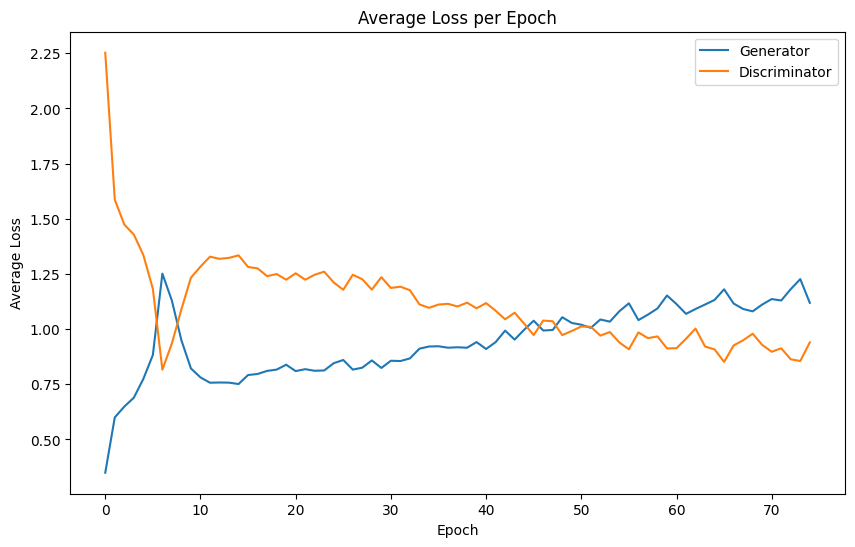

In [51]:
plot_losses(generator_losses, discriminator_losses)

In [53]:
def create_gif(directory: str = path_run, output_file: str = f"{path_run}/output.gif"):

    files = sorted(os.listdir(directory))
    images = []
    for filename in files:
        if filename.endswith(".png"):
            img = imageio.v2.imread(os.path.join(directory, filename))
            images.append(img)
    imageio.mimsave(output_file, images, duration=0.5)


create_gif()